# Atlanta lv2 EVCS

In [1]:
import geopandas as gpd
import pandas as pd
import yaml

from src import process_ev_charging_data, greedy_optimization, setup_logging

## POI Filtering and Initial Point Selection for EVCS Optimization

In this study, we explore the process of filtering and selecting Point of Interest (POI) candidates, categorized by region, for the placement of Electric Vehicle Charging Stations (EVCS). Our approach is designed to ensure optimal placement of EVCS across diverse spatial units—urban, suburban, and rural—while mitigating the risks associated with local optima during optimization.

### POI Filtering for Candidate Selection

POI filtering plays a vital role in selecting candidate locations for EVCS installations. The process begins with importing OSM_POI (OpenStreetMap Points of Interest) data, followed by extracting relevant POIs for each categorized region (Atlanta, Suburban, Rural) using GIS tools. 

The filtering process leverages the `fclass` column, which contains information about building usage. By applying region-specific filtering criteria based on this classification, we can refine the selection of candidate locations. This approach is consistently applied across all regions to ensure that the selected POIs align with the intended use cases of the area.

### Initial POI Selection for Greedy Optimization

Given that we utilize a **Greedy Algorithm** for EVCS placement optimization, there is a high risk of the algorithm falling into **local optima**—where the solution may become trapped in suboptimal configurations. To mitigate this risk, selecting **initial points**—locations where EVCS must be constructed—is critical.

Our study categorizes the problem based on **Charger Type** and **Spatial Units** (Urban, Suburban, Rural). Within each category, the problem is further divided into **cases**, with specific algorithms applied to ensure optimal initial point selection. This tailored approach improves the effectiveness of the optimization process by addressing the unique characteristics of each case and spatial unit.

Key steps in the initial POI selection include:
1. **Charger Type** Categorization: Differentiating between various types of chargers to tailor the optimization process to their specific needs.
2. **Spatial Unit Division**: Dividing the study area into urban, suburban, and rural regions, acknowledging the differing requirements and characteristics of each.
3. **Case-Specific Algorithm Application**: Applying algorithms that are specifically designed for each case and spatial unit, ensuring robust initial point selection that helps prevent local optimization pitfalls.

By incorporating region-specific POI filtering and strategic initial point selection, our approach enhances the placement of EVCS and ensures that the optimization process leads to effective and practical solutions.


In [2]:
# Load the YAML file with fclass categories
yaml_file_path = 'poi_filtering.yaml'

with open(yaml_file_path, 'r') as file:
    fclass_data = yaml.safe_load(file)

# Define the region and file paths
region = 'atlanta'
gpkg_file_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/poi/osm_poi_filtered_candidate.shp'

# Load the fclass categories for initial and candidate filtering from the YAML data
if region in fclass_data['initial'] and region in fclass_data['candidate']:
    initial_fclasses = fclass_data['initial'][region]
    candidate_fclasses = fclass_data['candidate'][region]
else:
    raise ValueError(f"Region '{region}' not found in the YAML file for both initial and candidate.")

# Read the GPKG or Shapefile only once
poi_gdf = gpd.read_file(gpkg_file_path)
poi_gdf = poi_gdf.to_crs(epsg=3857)

# Step 1: Filter the POI data based on the initial fclass categories
initial_poi_gdf = poi_gdf[poi_gdf['fclass'].isin(initial_fclasses)]
initial_feature_count = initial_poi_gdf.shape[0]
print(f"Initial feature count for {region}: {initial_feature_count}")

# Step 2: Filter the POI data based on the candidate fclass categories
candidate_poi_gdf = poi_gdf[poi_gdf['fclass'].isin(candidate_fclasses)]
candidate_feature_count = candidate_poi_gdf.shape[0]
print(f"Candidate feature count for {region}: {candidate_feature_count}")

Initial feature count for atlanta: 1315
Candidate feature count for atlanta: 7852


In [3]:
# Load the urban polygon file
urban_polygon_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/urban_polygon.gpkg'

# Load the urban polygon data
urban_polygon_gdf = gpd.read_file(urban_polygon_path)
urban_polygon_gdf = urban_polygon_gdf.to_crs(epsg=3857)

# Assuming initial_poi_gdf and candidate_poi_gdf are already selected and loaded in memory

# Step 1: Calculate the initial feature count for the given region
initial_feature_count = initial_poi_gdf.shape[0]
print(f"Initial feature count for {region}: {initial_feature_count}")

# Step 2: Calculate the candidate feature count for the given region
candidate_feature_count = candidate_poi_gdf.shape[0]
print(f"Candidate feature count for {region}: {candidate_feature_count}")

# Perform any spatial operations, e.g., checking which POIs are within the urban polygons
initial_within_urban = gpd.sjoin(initial_poi_gdf, urban_polygon_gdf, how='inner', predicate='within')
candidate_within_urban = gpd.sjoin(candidate_poi_gdf, urban_polygon_gdf, how='inner', predicate='within')

# Print counts of points within urban polygons
print(f"Initial POIs within urban polygons: {initial_within_urban.shape[0]}")
print(f"Candidate POIs within urban polygons: {candidate_within_urban.shape[0]}")

# Step 3: Remove 'index_right' column if it exists before saving
if 'index_right' in initial_within_urban.columns:
    initial_within_urban = initial_within_urban.drop(columns=['index_right'])
    
if 'index_right' in candidate_within_urban.columns:
    candidate_within_urban = candidate_within_urban.drop(columns=['index_right'])

# Save the results
initial_within_urban_path = 'initial_within_urban.gpkg'
candidate_within_urban_path = 'candidate_within_urban.gpkg'

initial_within_urban.to_file(initial_within_urban_path, driver='GPKG')
candidate_within_urban.to_file(candidate_within_urban_path, driver='GPKG')

print(f"Initial POIs within urban polygons saved to {initial_within_urban_path}.")
print(f"Candidate POIs within urban polygons saved to {candidate_within_urban_path}.")

Initial feature count for atlanta: 1315
Candidate feature count for atlanta: 7852
Initial POIs within urban polygons: 673
Candidate POIs within urban polygons: 4095
Initial POIs within urban polygons saved to initial_within_urban.gpkg.
Candidate POIs within urban polygons saved to candidate_within_urban.gpkg.


## Pre-processing for the Greedy Model

To input the estimated EV charging ports for each region (urban = Atlanta, suburban, rural county) into the greedy optimization model, the following conditions need to be met:

### Required Conditions:

1. **Polygon Data**: Geographical boundaries of the target region.
2. **Total Supply to be Distributed**: Estimated number of EV charging ports that need to be distributed across the region.
3. **Initial Points for the Greedy Algorithm**: Pre-selected locations where EV charging stations must be placed to prevent local optima in the greedy algorithm.
4. **Candidate Points for Selection**: Locations determined based on the calculation of demand and supply ratios, which can be considered for placing additional EV charging stations.
5. **Total Number of Points to be Selected (`p`)**: The number of charging stations that will be selected within the target polygon, determined by the demand-to-supply ratio.

Initial POIs within urban polygons: 673
Candidate POIs within urban polygons: 4095
Data saved to urban_lv2_greedy.gpkg


/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/src/utils.py:171: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[0].legend()


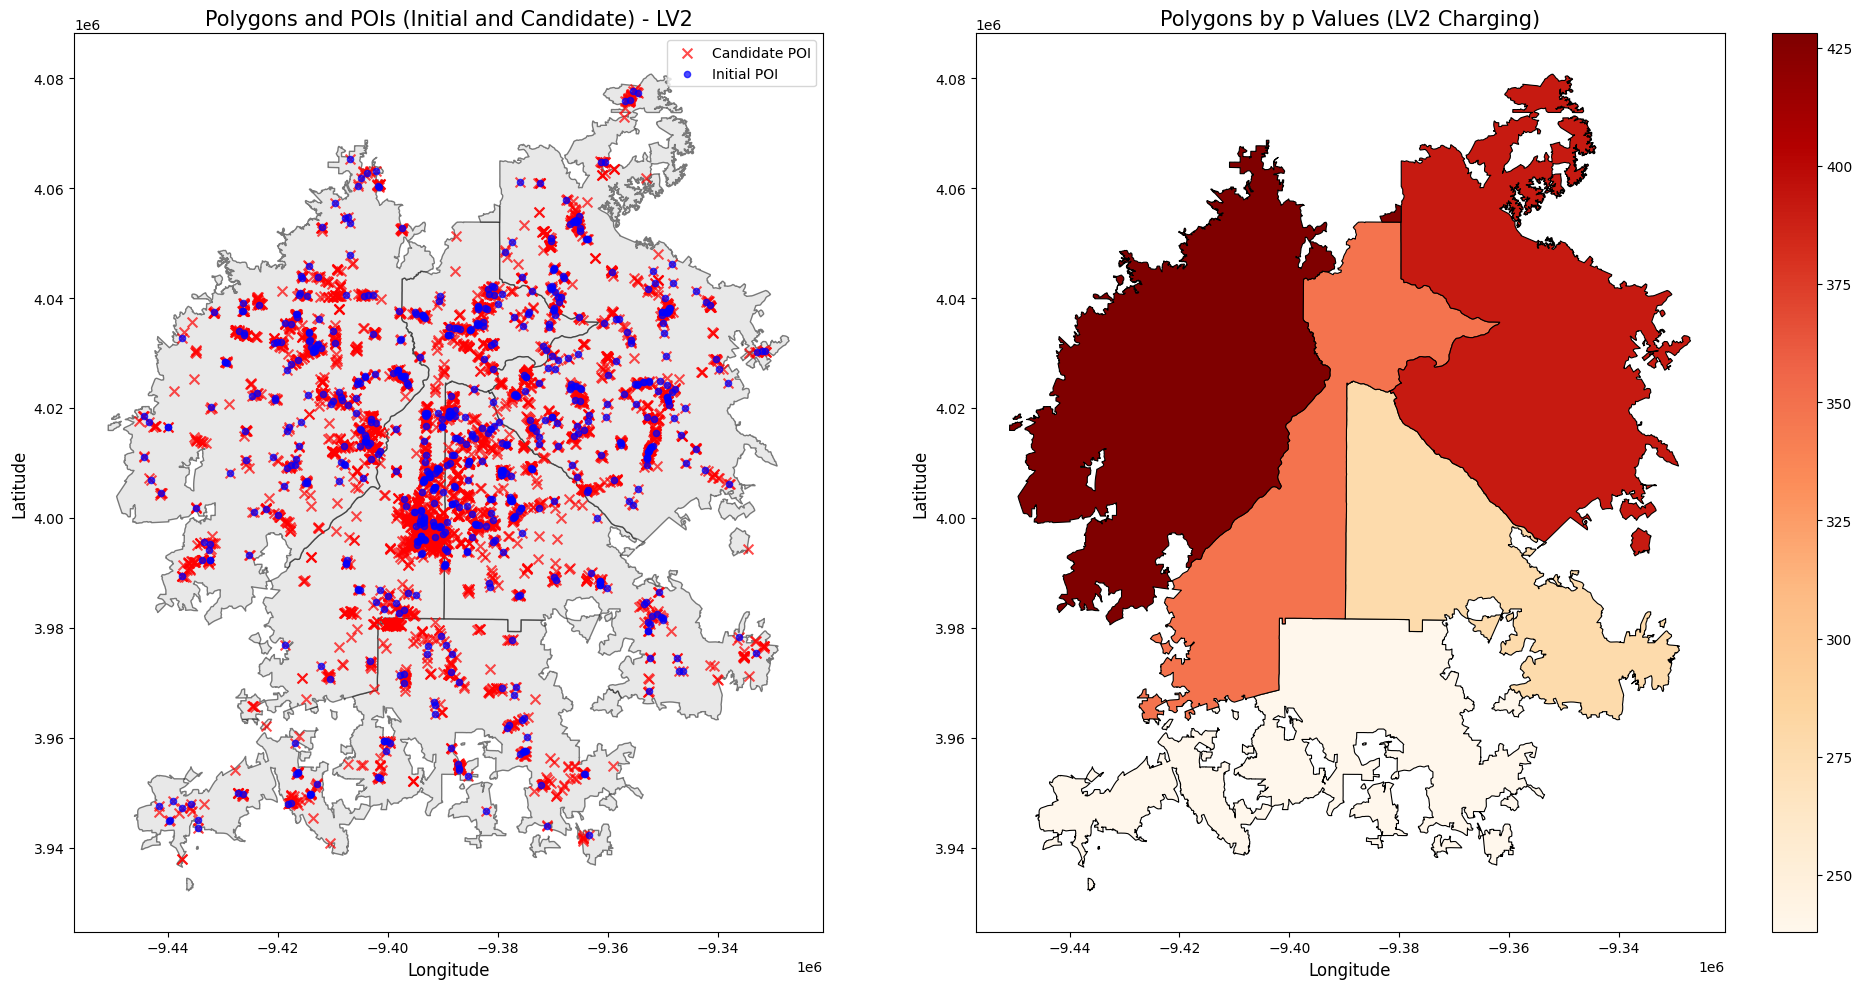

In [4]:
# Example usage
process_ev_charging_data(
    region_type='urban',
    initial_pois_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/initial_within_urban.gpkg',
    candidate_pois_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/candidate_within_urban.gpkg',
    polygons_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/urban_polygon.gpkg',
    charger_type='lv2',
    urban_polygons_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/urban_polygon.gpkg',
    save=True
)

## Greedy Optimization for EV Charging Station Placement

This section outlines the final steps for running the **Greedy Optimization** algorithm to place EV charging stations within suburban regions. The process utilizes geospatial data, including polygons representing regions of interest, a demand map in `.tif` format, and candidate Points of Interest (POI) data. The result is the optimized placement of EV charging stations based on various constraints and parameters.

### Input Data and Parameters

The following data sources are used as inputs for the greedy optimization process:

- **Polygon Data (`suburban_trip_greedy.gpkg`)**: Contains the suburban polygons where the EV charging stations will be placed.
- **Demand Map (`demand_map_500.tif`)**: A raster file that represents the demand for EV charging stations, which is used to calculate optimal placement.
- **POI Data (`Suburban_POI_Candidate.gpkg`)**: Contains the candidate Points of Interest that can potentially be selected as EV charging station locations.

The optimization process is designed to:
1. **Capture Demand** within a defined range around each selected point.
2. Apply **bandwidth** to control the spread of demand.
3. Respect **constraints**, such as the minimum and maximum number of stations to be selected.

### Parameters:
- **`capture_range=4000`**: The radius (in meters) within which demand is captured around selected points.
- **`bandwidth=1500`**: The bandwidth (in meters) used to spread the demand across the surrounding area.
- **`constraints=(2, 25)`**: Sets the minimum (2) and maximum (25) number of EV charging stations that can be placed within the region.
- **`output_path="./results/urban_lv2/"`**: The directory where intermediate and final results of the optimization will be saved.
- **`save_intermediate=True`**: Ensures that intermediate results are saved during the process for further analysis.

In [5]:
# Set up logging
setup_logging()

gpkg_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/urban_trip_greedy.gpkg"
tif_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/demand_map_500.tif"
poi_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/initial_candidate_poi/Atlanta_POI_Candidate.gpkg"
output_path = "./results/urban_lv2/"

# Read input files
polygons = gpd.read_file(gpkg_file)
poi_gdf = gpd.read_file(poi_file)

for _, polygon in polygons.iterrows(): 
    greedy_optimization(
        polygon, 
        tif_file, 
        poi_gdf, 
        capture_range=3000, 
        bandwidth=1000, 
        constraints=(2, 25), 
        output_path=output_path,
        save_intermediate=True
    )

2024-09-28 22:07:34,743 - INFO - 
*** Processed Polygon Information ***
--------------------------------------------------
Polygon ID            : Atlanta, GA Urban Area_6
Total Supply          : 953.0
A_bar Value           : 0.0074
Selected Initial Sites: 40
Initial Coverage      : 36.95%
2024-09-28 22:07:42,732 - INFO - Selecting site 41/238 | Selected Site: 116 | A_hat: 0.01426 | Coverage:  36.95%
2024-09-28 22:07:49,903 - INFO - Selecting site 42/238 | Selected Site: 106 | A_hat: 0.01366 | Coverage:  41.83%
2024-09-28 22:07:57,968 - INFO - Selecting site 43/238 | Selected Site: 412 | A_hat: 0.01313 | Coverage:  44.67%


KeyboardInterrupt: 